# Hierarchical Clustreing: Cereal - Assignment 5
   
   

In [166]:
import pandas as pd
import numpy as np
import hdbscan

from sklearn.preprocessing import Normalizer
from sklearn import preprocessing, datasets
from sklearn.cluster import AgglomerativeClustering, MeanShift as ms
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import train_test_split
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot
from sklearn.metrics import pairwise
from sklearn.cluster import KMeans
from pandas.plotting import parallel_coordinates

import matplotlib.pyplot as plt

In [167]:
#import data
Cereal = pd.read_csv('Cereals.csv') 
Cereal.set_index('name', inplace=True)

In [168]:
#convert value types to float64 (this did not convert all values and gave an error on mfr and type. For this I corrected by using
# One hot encoder to encode the values)
df = Cereal.astype(np.float64, errors='ignore')

In [169]:
#normalize data using max/min method
def norm_min_max(df):
    return(df-df.min())*1.0/(df.max()-df.min())

In [170]:
#remove NA values
df= df.dropna(how='any',axis=0)

In [171]:
#check data type to see what needs to change
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 100%_Bran to Wheaties_Honey_Gold
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mfr       74 non-null     object 
 1   type      74 non-null     object 
 2   calories  74 non-null     float64
 3   protein   74 non-null     float64
 4   fat       74 non-null     float64
 5   sodium    74 non-null     float64
 6   fiber     74 non-null     float64
 7   carbo     74 non-null     float64
 8   sugars    74 non-null     float64
 9   potass    74 non-null     float64
 10  vitamins  74 non-null     float64
 11  shelf     74 non-null     float64
 12  weight    74 non-null     float64
 13  cups      74 non-null     float64
 14  rating    74 non-null     float64
dtypes: float64(13), object(2)
memory usage: 9.2+ KB


In [172]:
#Call one hot encoder to encode the non-numeric values
le = preprocessing.LabelEncoder()

In [173]:
#encode mfr data
df['mfr'] = le.fit_transform(df.mfr)

In [174]:
#encode type data
df['type'] = le.fit_transform(df.type)

In [175]:
#check label encoder worked 
df.join(pd.get_dummies(df.mfr))
df.join(pd.get_dummies(df.type))

,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating,0,1
name,,,,,,,,,,,,,,,,,
100%_Bran,3,0,70.0,4.0,1.0,130.0,10.0,5.0,6.0,280.0,25.0,3.0,1.0,0.33,68.402973,1,0
100%_Natural_Bran,5,0,120.0,3.0,5.0,15.0,2.0,8.0,8.0,135.0,0.0,3.0,1.0,1.00,33.983679,1,0
All-Bran,2,0,70.0,4.0,1.0,260.0,9.0,7.0,5.0,320.0,25.0,3.0,1.0,0.33,59.425505,1,0
All-Bran_with_Extra_Fiber,2,0,50.0,4.0,0.0,140.0,14.0,8.0,0.0,330.0,25.0,3.0,1.0,0.50,93.704912,1,0
Apple_Cinnamon_Cheerios,1,0,110.0,2.0,2.0,180.0,1.5,10.5,10.0,70.0,25.0,1.0,1.0,0.75,29.509541,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Triples,1,0,110.0,2.0,1.0,250.0,0.0,21.0,3.0,60.0,25.0,3.0,1.0,0.75,39.106174,1,0
Trix,1,0,110.0,1.0,1.0,140.0,0.0,13.0,12.0,25.0,25.0,2.0,1.0,1.00,27.753301,1,0
Wheat_Chex,6,0,100.0,3.0,1.0,230.0,3.0,17.0,3.0,115.0,25.0,1.0,1.0,0.67,49.787445,1,0


In [176]:
#show variable distance table
d = pairwise.pairwise_distances(df, metric='euclidean')
pd.DataFrame(d, columns=df.index, index=df.index).head(5)

name,100%_Bran,100%_Natural_Bran,All-Bran,All-Bran_with_Extra_Fiber,Apple_Cinnamon_Cheerios,Apple_Jacks,Basic_4,Bran_Chex,Bran_Flakes,Cap'n'Crunch,...,Special_K,Strawberry_Fruit_Wheats,Total_Corn_Flakes,Total_Raisin_Bran,Total_Whole_Grain,Triples,Trix,Wheat_Chex,Wheaties,Wheaties_Honey_Gold
name,,,,,,,,,,,,,,,,,,,,,
100%_Bran,0.000000,196.616725,136.336330,60.854063,223.258539,256.036175,208.870801,172.771349,123.372600,270.852946,...,250.359086,223.524388,270.919607,135.703906,202.440747,256.186414,261.900448,196.691773,187.600776,236.972592
100%_Natural_Bran,196.616725,0.000000,313.221544,250.967878,179.542698,154.701827,200.273572,190.153161,207.407239,230.117736,...,232.063854,65.453498,233.622733,224.054261,213.383832,248.661019,169.029044,219.152613,190.599212,201.697594
All-Bran,136.336330,313.221544,0.000000,126.992546,267.392299,323.699839,234.911601,205.536648,141.051297,295.317965,...,270.042711,336.797347,304.565629,156.997948,233.476844,264.573339,322.808887,209.950013,220.924896,271.114696
All-Bran_with_Extra_Fiber,60.854063,250.967878,126.992546,0.000000,277.842776,312.838984,260.240747,222.312439,166.935526,323.154468,...,298.699625,276.053525,321.310498,175.536575,250.071155,303.250861,318.358077,242.871927,237.679892,289.335978
Apple_Cinnamon_Cheerios,223.258539,179.542698,267.392299,277.842776,0.000000,68.271454,48.190197,65.407082,127.781649,55.524634,...,58.168300,170.214132,86.623410,179.651476,90.036998,72.516173,60.362628,71.810165,51.799672,24.085181


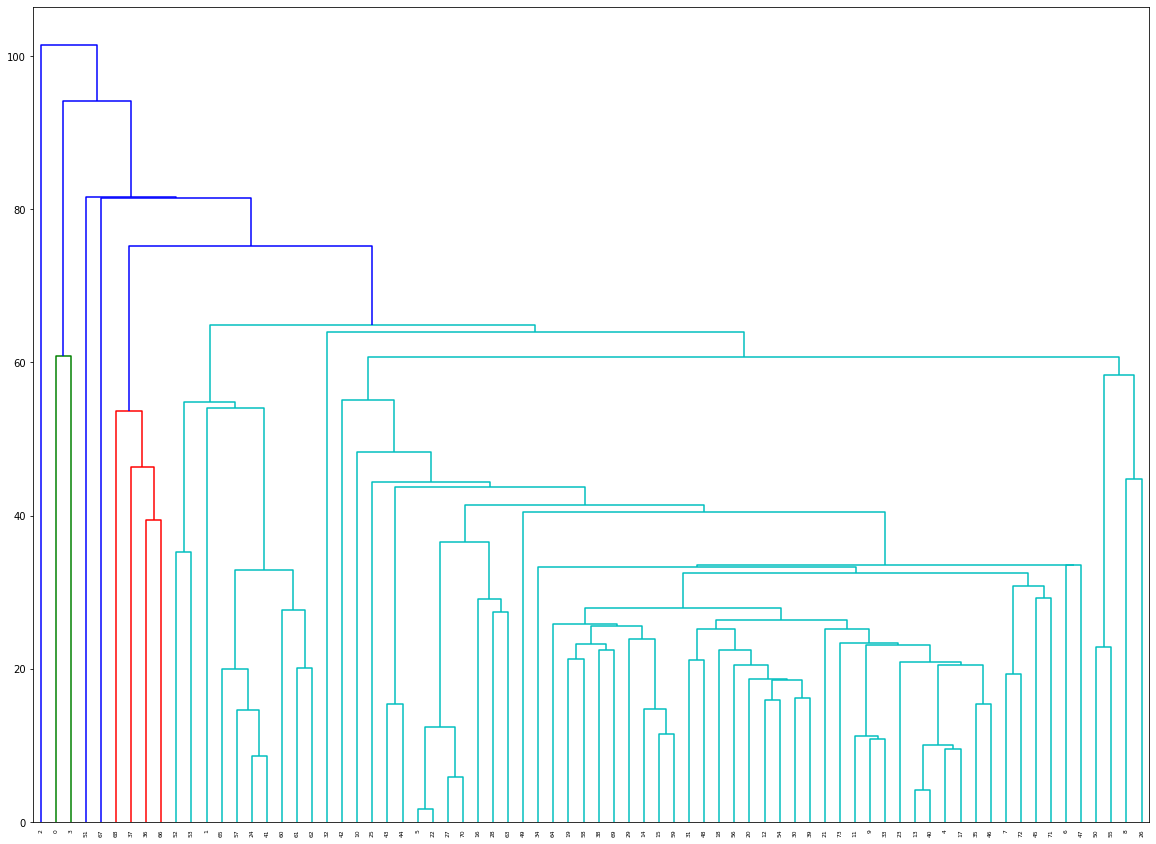

In [177]:
#plot dendrogram based on single linkage
plt.figure(figsize=(20, 15))
dendrogram = sch.dendrogram(sch.linkage(df, method='single'))

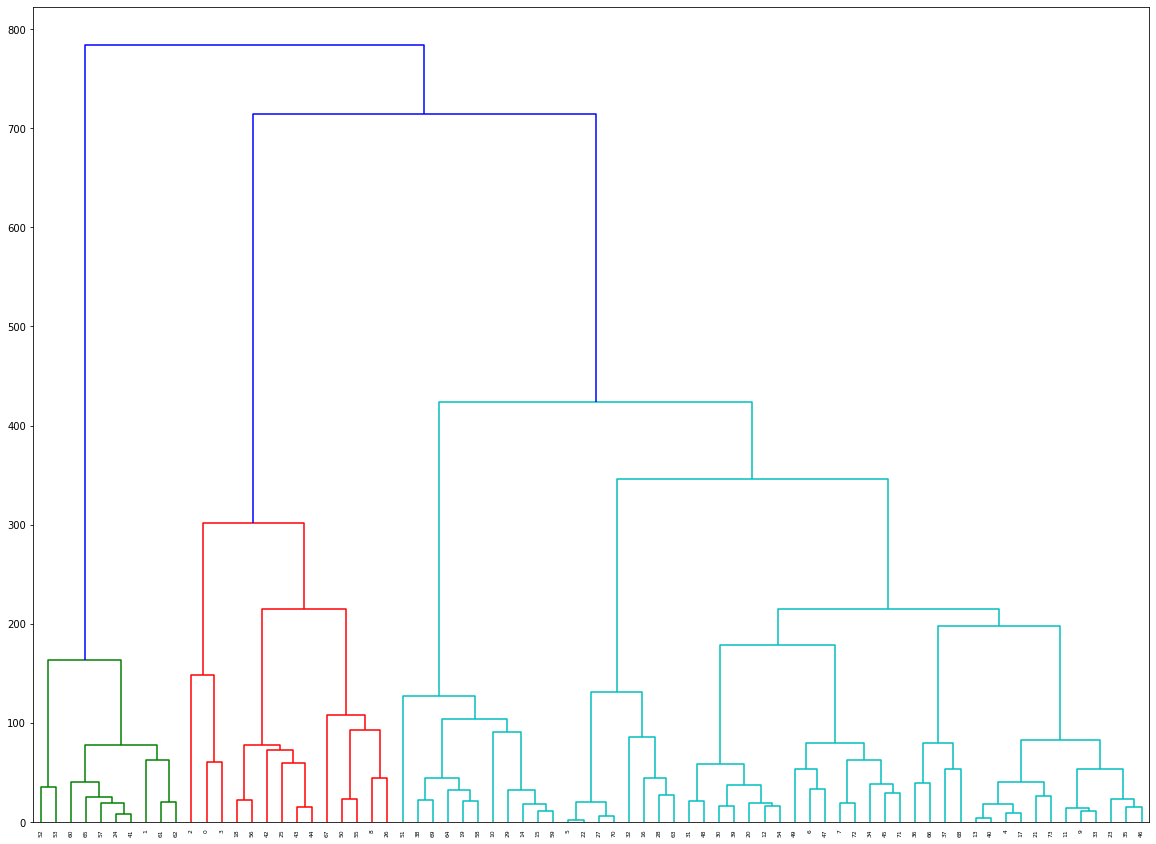

In [178]:
#plot dendrogram based on ward linkage
plt.figure(figsize=(20, 15))
dendrogram = sch.dendrogram(sch.linkage(df, method='ward'))

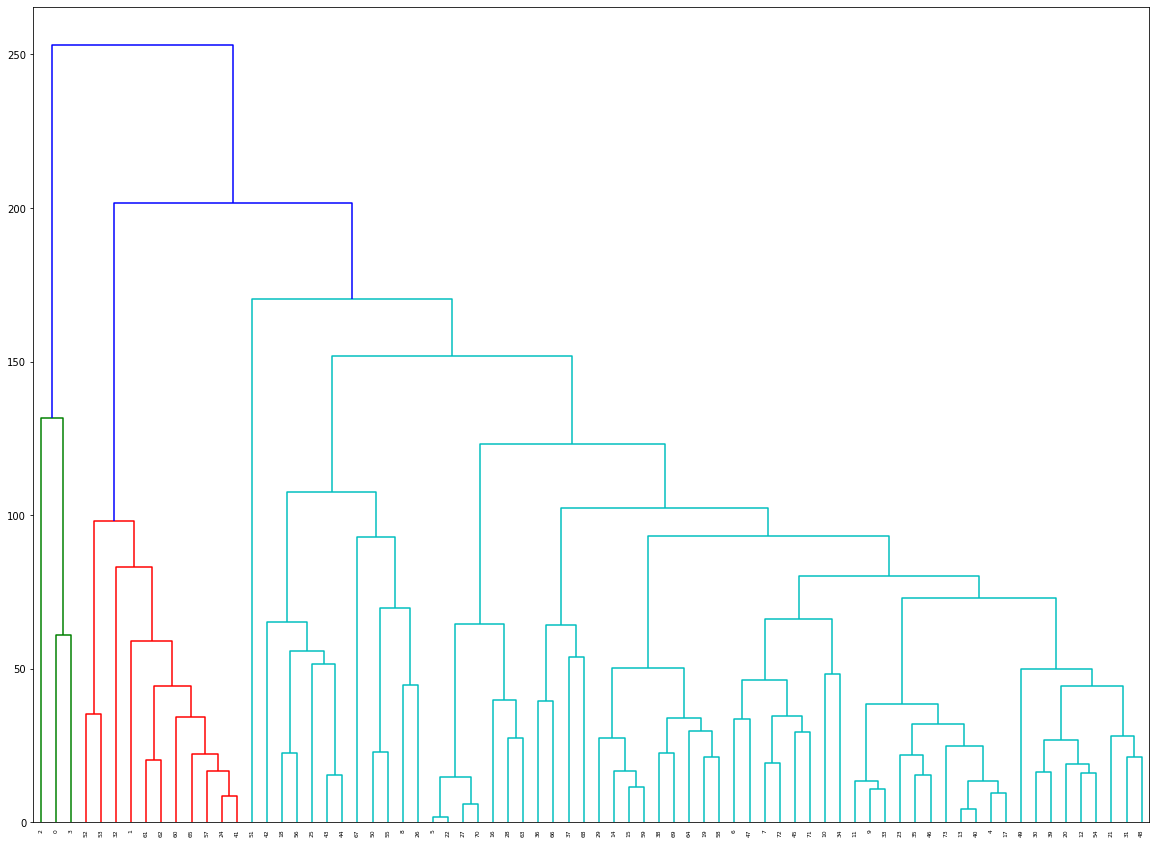

In [179]:
#plot dendrogram based on average linkage
plt.figure(figsize=(20, 15))
dendrogram = sch.dendrogram(sch.linkage(df, method='average'))

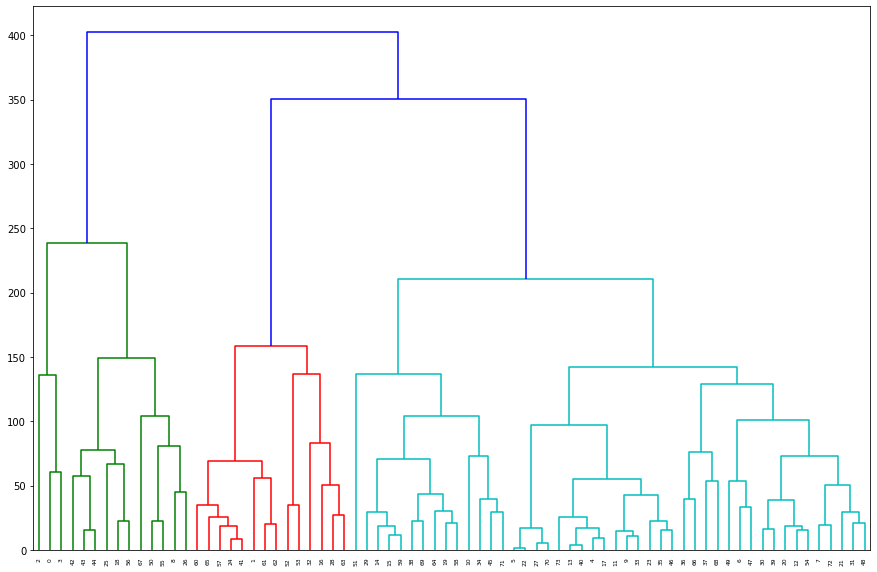

In [180]:
#plot dendrogram based on complete linkage
plt.figure(figsize=(15, 10))
dendrogram = sch.dendrogram(sch.linkage(df, method='complete'))

# Comment on the differneces between Hierarchical Clustreing and K-Means. How many clusters should be used?

>There are some major differences between K-means and Hierarchical clustering that should be noted.  K-means can easily adapt to new data entries
>while hierarchical clusering is more ridgid and will not adapt once clusters are set. Another notable difference is that hierarchical clusering
>produces a dendrogram for visualizing the clusters, which makes it more pratical for smaller batches of data.  K-means is typically plotted
>as a scatterplot, making it more friendly for larger sets of data. However, a downfall of k-means clustering is that it assumes that data
>is spherical and will not adjust to outliers as well becuase of this assumption. (this is an area where HDBSCAN surpasses both)


# How many clusters should be used?
> After looking at the different methods for linkage, it appears that most of these graphs 
> support having 2-3 clusters.  The method for determining this is the flat cut 
> where typically you would 'cut' the threads of your clusters on the highest uninterrupted line.
> Each of these clusting maps provide a slightly different 'recommended' clustering method.
> We can see later on that with k-means on the same data, using the Elbow method, it supports the same
> number of clusters as ideal.

# It is also important to note the alternative to K-Means & Hierarchical Clustering...
> HDBSCAN is a great alternative to kNN or Heirarchal Clustering because it deals with distance differently. HDBSCAN is an evolution of
> DBSCAN.  DBSCAN is nutoriously sensitvie when it comes to setting the Epsiol and Minpts -- which will substantially affect clusters.

> HDBSCAN is also a great algorithm for the Cereal classification project becuase it is an algorithm that is designed to work with 
> small datasets. The distance measure used in this algorithm is mutual reachability which is based primarily off desintiy of data points.

> Another reason to use HDBSCAN over Hierarchical Clustering is due to the fact that it works well with non-spherical data, where other 
> clustering algorithms add some primary assumptions that data points will be spherical on a graph. 

# . . .Demonstration below

In [181]:
# call HDBSCAN
clusterer = hdbscan.HDBSCAN()

In [182]:
# Take prepared data and fit to HDBSCAN - this will assign clusters properly accounting
# for noise
clusterer.fit(df)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [183]:
#This array will show how the clusters fall. -1 indicates noise in data sample
clusterer.labels_

array([-1,  0, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  0,  1, -1,  1, -1,  1,  1,  1,  0,  1,
        1,  1, -1, -1,  1,  1,  1,  0, -1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1, -1,  1, -1,  1,  0,  1,  1,  0,  0,  0,  1,  1,  0, -1, -1,
       -1,  1,  1,  1,  1,  1])

In [184]:
# This shows optimal amount of clusters. List starts at 0. This indicates that there are two 
# optimal clusters(0 and 1).
clusterer.labels_.max()

1

In [185]:
clusterer.probabilities_

array([0.        , 0.70878284, 0.        , 0.        , 1.        ,
       1.        , 1.        , 1.        , 0.        , 1.        ,
       0.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.        , 1.        , 0.        , 1.        ,
       1.        , 1.        , 0.59244389, 1.        , 1.        ,
       1.        , 0.        , 0.        , 1.        , 1.        ,
       1.        , 1.        , 0.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.7555975 , 1.        , 1.        , 1.        ,
       0.93122484, 0.        , 0.        , 0.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [186]:
memb = pd.Series(clusterer.labels_, index=df_norm.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

-1 :  100%_Bran, All-Bran, All-Bran_with_Extra_Fiber, Bran_Flakes, Cheerios, Fruitful_Bran, Golden_Crisp, Just_Right_Crunchy__Nuggets, Just_Right_Fruit_&_Nut, Muesli_Raisins,_Dates,_&_Almonds, Post_Nat._Raisin_Bran, Product_19, Puffed_Rice, Puffed_Wheat, Raisin_Bran, Total_Corn_Flakes, Total_Raisin_Bran, Total_Whole_Grain
0 :  100%_Natural_Bran, Frosted_Mini-Wheats, Great_Grains_Pecan, Maypo, Raisin_Squares, Shredded_Wheat, Shredded_Wheat_'n'Bran, Shredded_Wheat_spoon_size, Strawberry_Fruit_Wheats
1 :  Apple_Cinnamon_Cheerios, Apple_Jacks, Basic_4, Bran_Chex, Cap'n'Crunch, Cinnamon_Toast_Crunch, Clusters, Cocoa_Puffs, Corn_Chex, Corn_Flakes, Corn_Pops, Count_Chocula, Cracklin'_Oat_Bran, Crispix, Crispy_Wheat_&_Raisins, Double_Chex, Froot_Loops, Frosted_Flakes, Fruit_&_Fibre_Dates,_Walnuts,_and_Oats, Fruity_Pebbles, Golden_Grahams, Grape_Nuts_Flakes, Grape-Nuts, Honey_Graham_Ohs, Honey_Nut_Cheerios, Honey-comb, Kix, Life, Lucky_Charms, Muesli_Raisins,_Peaches,_&_Pecans, Mueslix_Crispy_B

# Check cluster stability and distance measures . . .

In [187]:
#Load data for preprocessing this time for k-means cluster analysis
df = pd.read_csv('Cereals.csv')
df.set_index('name', inplace=True)
df = df.apply(lambda x: x.astype('float64', errors='ignore'))

In [188]:
# One hot encoder for data encoding
df['mfr'] = le.fit_transform(df.mfr)

In [189]:
df['type'] = le.fit_transform(df.type)

In [190]:
# Drop NA values from data
df= df.dropna(how='any',axis=0)

In [191]:
# scale data and apply K-means
df_norm = df.apply(preprocessing.scale, axis=0)

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_norm)

In [192]:
# You can see the cluster distribution is different using K-means versus HBDSCAN
memb = pd.Series(kmeans.labels_, index=df_norm.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

0 :  100%_Natural_Bran, Basic_4, Cracklin'_Oat_Bran, Fruit_&_Fibre_Dates,_Walnuts,_and_Oats, Fruitful_Bran, Just_Right_Fruit_&_Nut, Muesli_Raisins,_Dates,_&_Almonds, Muesli_Raisins,_Peaches,_&_Pecans, Mueslix_Crispy_Blend, Nutri-Grain_Almond-Raisin, Oatmeal_Raisin_Crisp, Post_Nat._Raisin_Bran, Raisin_Bran, Total_Raisin_Bran
1 :  100%_Bran, All-Bran, All-Bran_with_Extra_Fiber, Bran_Chex, Bran_Flakes, Cheerios, Clusters, Double_Chex, Frosted_Mini-Wheats, Grape_Nuts_Flakes, Grape-Nuts, Great_Grains_Pecan, Life, Maypo, Nutri-grain_Wheat, Puffed_Rice, Puffed_Wheat, Quaker_Oat_Squares, Raisin_Nut_Bran, Raisin_Squares, Shredded_Wheat, Shredded_Wheat_'n'Bran, Shredded_Wheat_spoon_size, Special_K, Strawberry_Fruit_Wheats, Total_Whole_Grain, Wheat_Chex, Wheaties
2 :  Apple_Cinnamon_Cheerios, Apple_Jacks, Cap'n'Crunch, Cinnamon_Toast_Crunch, Cocoa_Puffs, Corn_Chex, Corn_Flakes, Corn_Pops, Count_Chocula, Crispix, Crispy_Wheat_&_Raisins, Froot_Loops, Frosted_Flakes, Fruity_Pebbles, Golden_Crisp, Go

In [193]:
# Show distance measures from cluster centers
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_norm.columns)
pd.set_option('precision', 3)
print(centroids)
pd.set_option('precision', 6)

     mfr   type  calories  protein    fat  sodium  fiber  carbo  sugars  \
0  0.124 -0.117     1.274    0.589  1.000   0.041  0.535 -0.013   0.767   
1  0.250  0.192    -0.791    0.589 -0.286  -0.491  0.498 -0.119  -0.800   
2 -0.273 -0.117     0.135   -0.773 -0.188   0.412 -0.670  0.110   0.365   

   potass  vitamins  shelf  weight   cups  rating  
0   0.995     0.220  0.862   1.415 -0.275  -0.435  
1   0.351    -0.264  0.084  -0.476 -0.391   0.991  
2  -0.742     0.134 -0.451  -0.202  0.463  -0.677  


In [194]:
#Here we can see the distribution of the clusters 
withinClusterSS = [0] * 3
clusterCount = [0] * 3
for cluster, distance in zip(kmeans.labels_, kmeans.transform(df_norm)):
    withinClusterSS[cluster] += distance[cluster]**2
    clusterCount[cluster] += 1
for cluster, withClustSS in enumerate(withinClusterSS):
    print('Cluster {} ({} members): {:5.2f} within cluster'.format(cluster, 
        clusterCount[cluster], withinClusterSS[cluster]))

Cluster 0 (14 members): 126.48 within cluster
Cluster 1 (28 members): 437.21 within cluster
Cluster 2 (32 members): 231.57 within cluster


,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating,cluster
0,0.123512,-0.117041,1.274310,0.588993,1.000000,0.040743,0.535368,-0.013235,0.766929,0.995167,0.220136,0.861971,1.415043,-0.275412,-0.435094,Cluster 0
1,0.250454,0.192282,-0.791424,0.588993,-0.285714,-0.491440,0.498273,-0.119492,-0.800371,0.350872,-0.263727,0.084095,-0.476432,-0.391349,0.991172,Cluster 1
2,-0.273184,-0.117041,0.134985,-0.773053,-0.187500,0.412185,-0.670213,0.110346,0.364793,-0.742399,0.134452,-0.450695,-0.202203,0.462924,-0.676922,Cluster 2


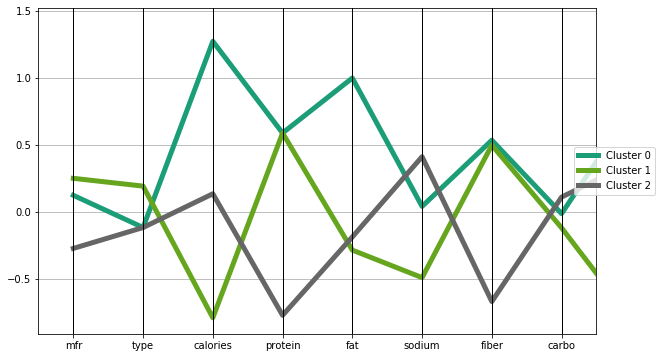

In [195]:
#Setup data for graph of items included in clusters.
centroids['cluster'] = ['Cluster {}'.format(i) for i in centroids.index]

plt.figure(figsize=(10,6))
fig.subplots_adjust(right=3)
ax = parallel_coordinates(centroids, class_column='cluster', colormap='Dark2', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,7.5)
centroids

In [196]:
print(pd.DataFrame(pairwise.pairwise_distances(kmeans.cluster_centers_, metric='euclidean')))

          0         1         2
0  0.000000  3.957791  3.802343
1  3.957791  0.000000  3.451459
2  3.802343  3.451459  0.000000


In [197]:
pd.DataFrame(pairwise.pairwise_distances(kmeans.cluster_centers_, metric='euclidean')).sum(axis=0)

0    7.760134
1    7.409250
2    7.253801
dtype: float64


# Comment on the structures of the clusters and their stability

> Judging by the differences in the groups when different cluster techniques are applied, it does appear that the clusters are not 
> completely stable.  However it does appear that multiple methods of evaluating the clusters show that 2-3 clusters would be the 
> best fit for this data.


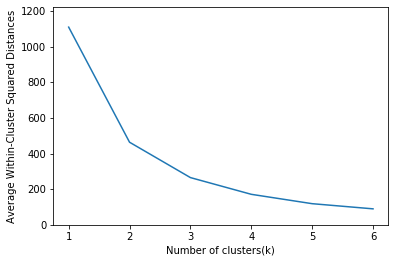

In [198]:
#Plot showing curve of k values.  This is to show the elbow of the graph for chosing the optimum value for K.
inertia = []
for n_clusters in range(1, 7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_norm)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 7), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

# Should you normalize data for a different "Healthy" cereal each day of the week? How would you cluster this?

> Looking at the nutrition values of the Cereal data, it does appear that it would be important to normalize the data.  The values have a 
> fairly broad range, so allowing the varibales to be on a similar scale would be helpful.
> The best way to select these cereals may not be a hierarchical cluster. This problem seems to be better suited for an 
> optimization matrix.  This would easily allow you to set the paramaters for what was healthy and then select the top 7.. or 14 if
> you would want a repeating 2 week cycle.




>A source of information on HBDSCAN used in this demonstration: https://www.youtube.com/watch?v=dGsxd67IFiU "HDBSCAN Fast Density
> Based Clustering,the How and Why" 